In [1]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

In [126]:
cv2.__version__
cv2.ocl.setUseOpenCL(False)

In [3]:
img1 = cv2.imread('SourceImages/stitch_l.png',0)          # queryImage
img2 = cv2.imread('SourceImages/stitch_m.png',0) # trainImage
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

In [11]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)



good_matches = [] # Append filtered matches to this list
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good_matches.append(m)
    # draw matches

# img_match = drawMatches(img1, kp1, img2, kp2, good_matches)
# estimate transform matrix using RANSAC
print(len(good_matches))



# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)

plt.imshow(img3),plt.show()

5


TypeError: Expected cv::DMatch for argument 'matches1to2'

In [13]:
def drawMatches(img1, kp1, img2, kp2, matches):
    rows1 = img1.shape[0]
    print("rows1 is "+ str(rows1))
    cols1 = img1.shape[1]
    print("cols1 is "+ str(cols1))
    rows2 = img2.shape[0]
    print("rows2 is "+ str(rows2))
    cols2 = img2.shape[1]
    print("cols2 is "+ str(cols2))

    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    # Place the first image to the left
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])
    # Place the next image to the right of it
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])
     # For each pair of points we have between both images
    # draw circles, then connect a line between them
    for mat in matches:
    # Get the matching keypoints for each of the images
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
    # x - columns
    # y - rows
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt
    # Draw a small circle at both co-ordinates
    # radius 4
    # colour blue
    # thickness = 1
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)
    # Draw a line in between the two points
    # thickness = 1
    # colour blue
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)
    # Also return the image if you'd like a copy
    return out




rows1 is 912
cols1 is 608
rows2 is 912
cols2 is 608


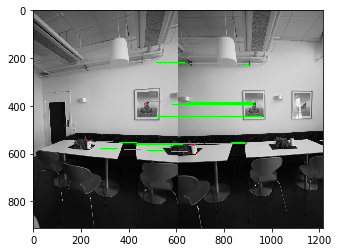

(<matplotlib.image.AxesImage at 0x84ece10>, None)

In [17]:
# cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)
matches = sorted(matches, key = lambda x:x.distance)
img4=drawMatches(img1, kp1, img2, kp2, matches[:10])
plt.imshow(img4),plt.show()

# Brute-Force Matching with SIFT Descriptors and Ratio Test

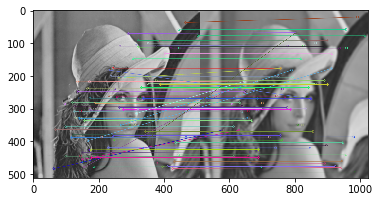

(<matplotlib.image.AxesImage at 0x8791320>, None)

In [49]:
img1 = cv2.imread('SourceImages/p1_01.jpg',0)          # queryImage
img2 = cv2.imread('SourceImages/p1_02.jpg',0) # trainImage
# Initiate SIFT detector

#sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create() # for cv 3.4 you have to use this 

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])

# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=2)

plt.imshow(img3),plt.show()



# FLANN based Matcher

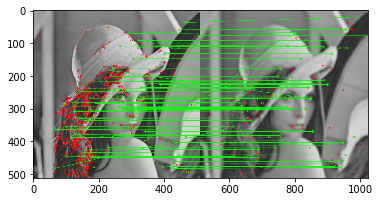

(<matplotlib.image.AxesImage at 0x8dab400>, None)

In [51]:
img1 = cv2.imread('SourceImages/p1_01.jpg',0)          # queryImage
img2 = cv2.imread('SourceImages/p1_02.jpg',0) # trainImage

# Initiate SIFT detector
#sift = cv2.SIFT()
sift = cv2.xfeatures2d.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(des1,des2,k=2)

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in xrange(len(matches))]

# ratio test as per Lowe's paper
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = 0)

img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)

plt.imshow(img3,),plt.show()

(648L, 1152L, 3L)
[[  1.26666667   0.6        -83.33333333]
 [ -0.33333333   1.          66.66666667]]


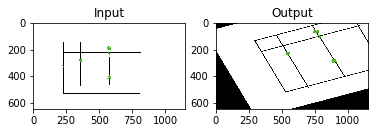

In [60]:
img = cv2.imread('SourceImages/draw.png')
rows,cols,ch = img.shape
print(img.shape)
#print(img[0])

pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
# print(pts1)
# print(pts2)

M = cv2.getAffineTransform(pts1,pts2)
print(M)

dst = cv2.warpAffine(img,M,(cols,rows))

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

(648L, 1152L, 3L)
(1152L, 648L)
[576 324]
(576, 324)


Text(0.5,1,'original img')

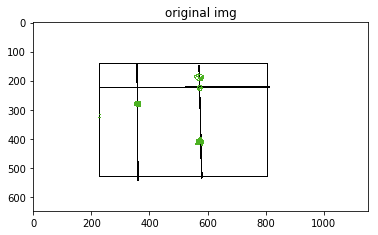

In [34]:
image = cv2.imread('SourceImages/draw.png')
print(image.shape)
print(image.shape[1::-1])
image_center = tuple(np.array(image.shape[1::-1]) / 2)
print(np.array(image.shape[1::-1]) / 2) 
print (tuple(np.array(image.shape[1::-1]) / 2))
rot_mat = cv2.getRotationMatrix2D(image_center, 90, 1.0)
result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
# plt.subplot(121),plt.imshow(image),plt.title('Input')
# plt.subplot(122),plt.imshow(result),plt.title('Output')
# plt.show()
plt.imshow(image, 'gray')
plt.title('original img')


In [3]:
img1 = cv2.imread('SourceImages/audrey.jpg',0)          # queryImage
img2 = cv2.imread('SourceImages/audrey.jpg',0) # trainImage
print(img1.shape)
orb = cv2.ORB_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = orb.detectAndCompute(img1,None)
kp2, des2 = orb.detectAndCompute(img2,None)

(1200L, 925L)


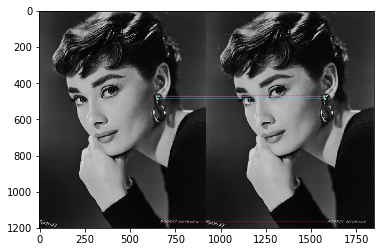

(<matplotlib.image.AxesImage at 0x7f83860>, None)

In [4]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) 
# Match descriptors.
matches = bf.match(des1,des2)  

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw first 10 matches.
img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None, flags=2)

plt.imshow(img3),plt.show()

In [9]:
def drawMatches(img1, kp1, img2, kp2, matches): 
    rows1 = img1.shape[0]
    cols1 = img1.shape[1]
    rows2 = img2.shape[0]
    cols2 = img2.shape[1]
    out = np.zeros((max([rows1,rows2]),cols1+cols2,3), dtype='uint8')
    out[:rows1,:cols1] = np.dstack([img1, img1, img1])
    out[:rows2,cols1:] = np.dstack([img2, img2, img2])
    for mat in matches:
        img1_idx = mat.queryIdx
        img2_idx = mat.trainIdx
        (x1,y1) = kp1[img1_idx].pt
        (x2,y2) = kp2[img2_idx].pt
        cv2.circle(out, (int(x1),int(y1)), 4, (255, 0, 0), 1)   
        cv2.circle(out, (int(x2)+cols1,int(y2)), 4, (255, 0, 0), 1)
        cv2.line(out, (int(x1),int(y1)), (int(x2)+cols1,int(y2)), (0,255,0), 2)
    return out

In [5]:
imgCenter = cv2.imread('SourceImages/stitch_m.png', 0)
imgRight  = cv2.imread('SourceImages/stitch_r.png', 0)
imgLeft   = cv2.imread('SourceImages/stitch_l.png', 0)
print(imgCenter.shape)
print(imgRight.shape)
print(imgLeft.shape)

(912L, 608L)
(912L, 608L)
(912L, 608L)


In [6]:
imgCenter = cv2.copyMakeBorder(imgCenter,200,200,500,500,cv2.BORDER_CONSTANT)

In [7]:
print(imgCenter.shape)

(1312L, 1608L)


In [101]:
imgCenter = cv2.imread('SourceImages/stitch_m.png', 0)
imgRight  = cv2.imread('SourceImages/stitch_r.png', 0)
imgLeft   = cv2.imread('SourceImages/stitch_l.png', 0)

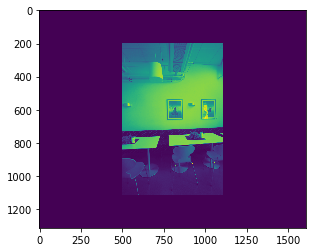

(<matplotlib.image.AxesImage at 0x1308bc50>, None)

In [102]:
imgCenter = cv2.copyMakeBorder(imgCenter,200,200,500,500,cv2.BORDER_CONSTANT)
# gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#     6 
#     7 sift = cv2.xfeatures2d.SIFT_create()
#     8 kp = sift.detect(gray,None)
plt.imshow(imgCenter),plt.show('gray')

(254L, 1L)
Transformation Matrix = 
[[  2.95396010e-01  -8.49096079e-03   6.91680113e+02]
 [ -3.95489573e-01   8.61433384e-01   2.60485658e+02]
 [ -6.33432573e-04   9.36178523e-06   1.00000000e+00]]


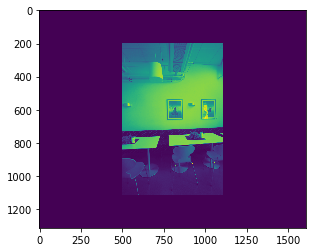

(-0.5, 1607.5, 1311.5, -0.5)

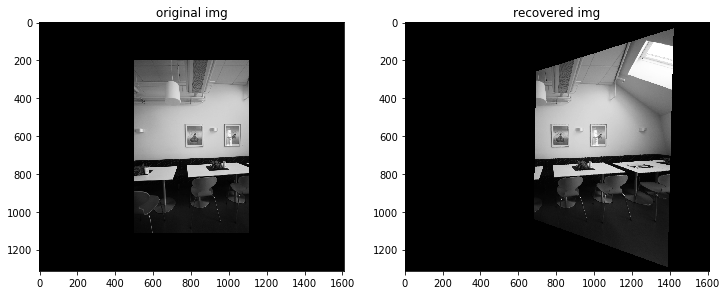

In [103]:
img_input = imgCenter
rotated_img=imgRight
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_input,None)
kp2, des2 = sift.detectAndCompute(rotated_img,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
good_matches = [] # Append filtered matches to this list
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)
if len(good_matches) > 4:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    rot, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0) #cv2.RANSAC
    print(mask.shape)
    print "Transformation Matrix = \n", rot  
    # mapping rotataed image back with the calculated rotation matrix
    # ===== This is your fourth output =====
    width=img_input.shape[0]
    height=img_input.shape[1]
    res4=cv2.warpPerspective(rotated_img, rot, (height,width), cv2.WARP_FILL_OUTLIERS, 200)
else:
    print "Not enough matches are found - %d/%d" % (len(good_matches),4)
    
plt.imshow(img_input),plt.show('gray')
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img_input, 'gray')
plt.title('original img')
plt.axis('on')    
plt.subplot(1, 2, 2)
plt.imshow(res4, 'gray')
plt.title('recovered img')  
plt.axis('on')

In [168]:
#compare img_input and res4
print(img_input.shape)
print(res4.shape)
imgMask_input=np.zeros(img_input.shape, dtype=int)
imgMask_res4=np.zeros(img_input.shape, dtype=int)

(1312L, 1608L)
(1312L, 1608L)


In [169]:
rows=img_input.shape[0]
cols=img_input.shape[1]
for x in range(0, rows):
    for y in range(0, cols):
        if(img_input[x][y]!=0):
            imgMask_input[x][y]=img_input[x][y]
        if(res4[x][y]!=0):
            imgMask_input[x][y]=res4[x][y]
        if(img_input[x][y]!=0 & res4[x][y]==0):
            imgMask_res4[x][y]=255
#         if(res4[x][y]!=0 & img_input[x][y]==0):
#             imgMask_res4[x][y]=res4[x][y]

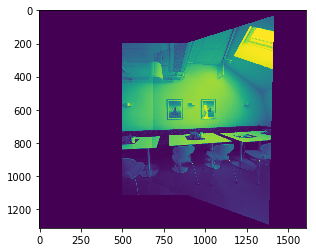

(<matplotlib.image.AxesImage at 0x12d08c88>, None)

In [170]:
plt.imshow(imgMask_input),plt.show()

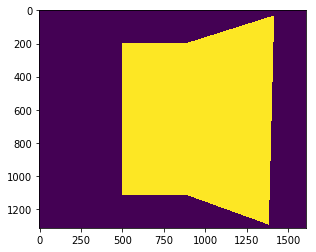

(<matplotlib.image.AxesImage at 0xd998588>, None)

In [171]:
plt.imshow(imgMask_res4),plt.show()

(-0.5, 1607.5, 1311.5, -0.5)

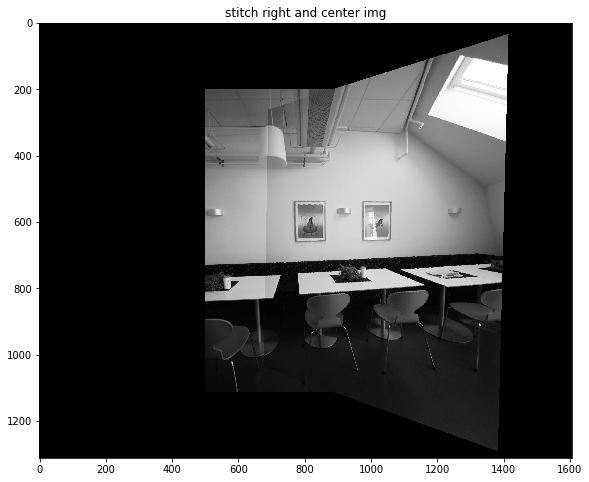

In [172]:
plt.figure(figsize=(12,8))
plt.imshow(imgMask_input, 'gray')
plt.title('stitch right and center img')
plt.axis('on')

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
(213L, 1L)
Transformation Matrix = 
[[  2.16115130e+00   3.40909739e-02   1.82824167e+02]
 [  6.46971375e-01   1.40208796e+00   3.20346665e+01]
 [  1.03737979e-03   4.27957481e-06   1.00000000e+00]]


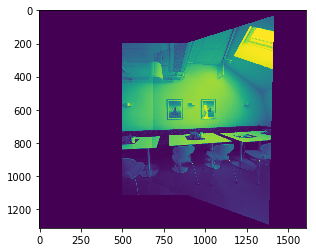

(-0.5, 1607.5, 1311.5, -0.5)

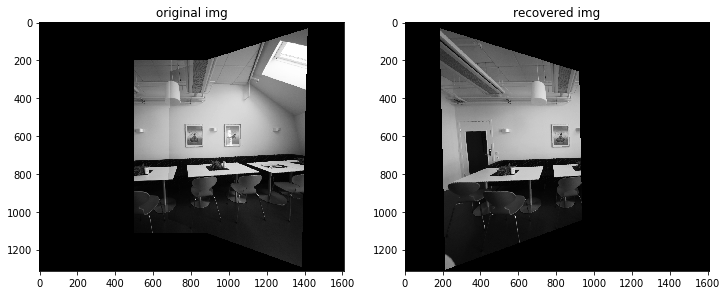

In [148]:
cv2.__version__
cv2.ocl.setUseOpenCL(True)
img_input = imgMask_input
img_input.astype(np.uint8)

new_image_red =img_input
new_image_blue = img_input
new_image_green=img_input
new_rgb = np.dstack([new_image_red, new_image_green, new_image_blue])
img_input=new_rgb
img_input=img_input.astype(np.uint8)
img_input=cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)


# img_input= cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)
print(type(img_input))
rotated_img=imgLeft
print(type(rotated_img))
sift = cv2.xfeatures2d.SIFT_create()
kp1, des1 = sift.detectAndCompute(img_input,None)
kp2, des2 = sift.detectAndCompute(rotated_img,None)
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=2)
good_matches = [] # Append filtered matches to this list
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good_matches.append(m)
if len(good_matches) > 4:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
    rot, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0) #cv2.RANSAC
    print(mask.shape)
    print "Transformation Matrix = \n", rot  
    # mapping rotataed image back with the calculated rotation matrix
    # ===== This is your fourth output =====
    width=img_input.shape[0]
    height=img_input.shape[1]
    res5=cv2.warpPerspective(rotated_img, rot, (height,width), cv2.WARP_FILL_OUTLIERS, 200)
else:
    print "Not enough matches are found - %d/%d" % (len(good_matches),4)
    
plt.imshow(img_input),plt.show('gray')
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
plt.imshow(img_input, 'gray')
plt.title('original img')
plt.axis('on')    
plt.subplot(1, 2, 2)
plt.imshow(res5, 'gray')
plt.title('recovered img')  
plt.axis('on')

In [149]:
print(img_input.shape)
print(res5.shape)
imgMask_final=np.zeros(img_input.shape, dtype=int)
rows=img_input.shape[0]
cols=img_input.shape[1]
for x in range(0, rows):
    for y in range(0, cols):
        if(img_input[x][y]!=0):
            imgMask_final[x][y]=img_input[x][y]
        if(res5[x][y]!=0):
            imgMask_final[x][y]=res5[x][y]

(1312L, 1608L)
(1312L, 1608L)


(-0.5, 1607.5, 1311.5, -0.5)

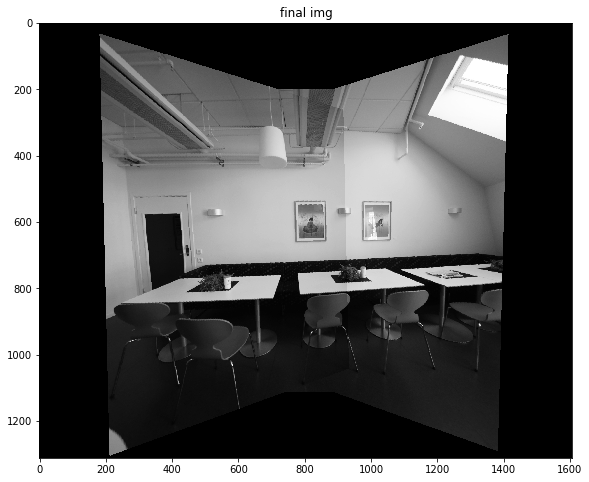

In [150]:
plt.figure(figsize=(12,8))
plt.imshow(imgMask_final, 'gray')
plt.title('final img')
plt.axis('on')

In [ ]:
# cv::Mat imgQuery, imgTrain;...    
# TRANSFORMATION_MATRIX = cv::findHomography(...)...
# cv::Mat imgTrainWarped;
# cv::warpPerspective(imgTrain, imgTrainWarped, TRANSFORMATION_MATRIX, imgTrain.size());
# imgTrain Over imgQuery# // imageRight over imageCenter
#########################################################################
cv::Mat imgMask = cv::Mat(imgTrain.size(), CV_8UC1, cv::Scalar(255));
cv::Mat imgMaskWarped;
cv::warpPerspective(imgMask , imgMaskWarped, TRANSFORMATION_MATRIX, imgQuery.size());

cv::Mat imgTrainWarped;
cv::warpPerspective(imgTrain, imgTrainWarped, TRANSFORMATION_MATRIX, imgQuery.size());

#now copy only masked pixel:
imgTrainWarped.copyTo(imgQuery, imgMaskWarped); # imgQuery ===imgCenter, imgMaskWarped=maskk imgTrain


res5=cv2.warpPerspective(imageRight,rot, (height, width),cv2.WARP_FILE_OUTLIERS,200)


In [79]:
import numpy as np
imgMask=np.zeros(imgRight.shape, dtype=int)
imgMask.fill(255)

In [80]:
width=imgCenter.shape[0]
height=imgCenter.shape[1]
imgMaskWarped=cv2.warpPerspective(imgMask, rot, (height,width), cv2.WARP_FILL_OUTLIERS,200)
imgRightWarped=cv2.warpPerspective(imgRight,rot,(height, width),cv2.WARP_FILL_OUTLIERS,200) #imageTrainWarped 
#imgRightWarped.copyTo(imgCenter, imgMaskWarped)

In [81]:
print(imgMaskWarped.shape)
print(imgRightWarped.shape)

(1712L, 2608L)
(1712L, 2608L)


In [85]:
rows=imgCenter.shape[0]
cols=imgCenter.shape[1]
count=0
for x in range(0, rows):
    for y in range(0, cols):
        if(imgMaskWarped[x][y]!=0):
            imgCenter[x][y]=imgRightWarped[x][y]
            count=count+1

In [86]:
print(count)

724361


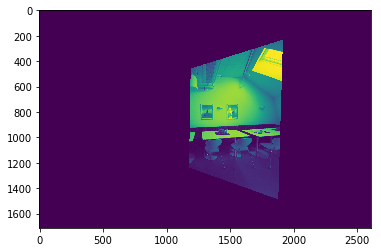

(<matplotlib.image.AxesImage at 0x12ff5a20>, None)

In [87]:
plt.imshow(imgCenter),plt.show('gray')

In [ ]:
def getTransform(img1, img2): ##img1 the imgcenter img2 the smaller one 
    img_input = img1
    rotated_img=img2
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img_input,None)
    kp2, des2 = sift.detectAndCompute(rotated_img,None)
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)
    good_matches = [] # Append filtered matches to this list
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good_matches.append(m)
    if len(good_matches) > 4:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good_matches ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good_matches ]).reshape(-1,1,2)
        rot, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC,5.0) #cv2.RANSAC
        print "Transformation Matrix = \n", rot  
    width=img_input.shape[0]
    height=img_input.shape[1]
    res4=cv2.warpPerspective(rotated_img, rot, (height,width), cv2.WARP_FILL_OUTLIERS, 200)
    else:
        print "Not enough matches are found - %d/%d" % (len(good_matches),4)